In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
#from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.mobilenet import MobileNet
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.resnet50 import ResNet50
#from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import argparse


%matplotlib inline

In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)

        img = cv2.imread(PATH)

        img = cv2.resize(img, (RESIZE,RESIZE))

        IMG.append(np.array(img))
    return IMG

In [ ]:
#load data
early_blight_norm_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Normal',224))
early_blight_serious_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Serious',224))
late_blight_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/LateBlight',224))
healthy_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Healthy',224))
insect_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Insect',224))
lrv_train = np.array(Dataset_loader('/content/drive/MyDrive/potato1/train1/LeafRoll',224))
virus_train =np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Virus',224))

early_blight_norm_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Normal',224))
early_blight_serious_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Serious',224))
late_blight_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/LateBlight',224))
healthy_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Healthy',224))
insect_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Insect',224))
lrv_test = np.array(Dataset_loader('/content/drive/MyDrive/potato1/test1/LeafRoll ',224))
virus_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Virus',224))

100%|██████████| 200/200 [00:11<00:00, 16.94it/s]


In [ ]:
print(len(lrv_test))

200


In [ ]:
# Create labels
early_blight_norm_train_label = np.full(len(early_blight_norm_train),0)
early_blight_serious_train_label = np.full(len(early_blight_serious_train),1)
late_blight_train_label = np.full(len(late_blight_train),2)
virus_train_label = np.full(len(virus_train),3)
insect_train_label = np.full(len(insect_train),4)
lrv_train_label = np.full(len(lrv_train),5)
healthy_train_label = np.full(len(healthy_train),6)

early_blight_norm_test_label = np.full(len(early_blight_norm_test),0)
early_blight_serious_test_label = np.full(len(early_blight_serious_test),1)
late_blight_test_label = np.full(len(late_blight_test),2)
virus_test_label = np.full(len(virus_test),3)
insect_test_label = np.full(len(insect_test),4)
lrv_test_label = np.full(len(lrv_test),5)
healthy_test_label = np.full(len(healthy_test),6)

In [ ]:
# Merge data
X_train = np.concatenate((early_blight_norm_train, early_blight_serious_train, late_blight_train, virus_train, insect_train, lrv_train, healthy_train), axis = 0)
Y_train = np.concatenate((early_blight_norm_train_label, early_blight_serious_train_label, late_blight_train_label, virus_train_label, insect_train_label, lrv_train_label, healthy_train_label), axis = 0)
X_test = np.concatenate((early_blight_norm_test, early_blight_serious_test, late_blight_test, virus_test, insect_test, lrv_test,  healthy_test), axis = 0)
Y_test = np.concatenate((early_blight_norm_test_label, early_blight_serious_test_label, late_blight_test_label, virus_test_label, insect_test_label, lrv_test_label, healthy_test_label), axis = 0)

In [ ]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [ ]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 7)
Y_test = to_categorical(Y_test, num_classes= 7)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

In [ ]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images

    )

In [ ]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

ras      = ResNet50(include_top=False, input_shape=input_shape)(inputs)
dennet   = DenseNet201(include_top=False, input_shape=input_shape)(inputs)
vgg      = VGG16(include_top=False, input_shape=input_shape)(inputs)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(ras), GlobalAveragePooling2D()(dennet), GlobalAveragePooling2D()(vgg)])
outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(128,activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(7, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=0.0001, decay=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_1[0][0]']             
                                                          2                                       
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_1[0][0]']             
                                                          4                                       
                                                                                              

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Drive/resDenseVgg16(7_classes)_old_pred.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=5,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/5
137/136 [==============================] - ETA: 0s - loss: 0.7502 - accuracy: 0.7275

136/136 [==============================] - 307s 2s/step - loss: 0.7502 - accuracy: 0.7275 - val_loss: 0.2098 - val_accuracy: 0.9241 - lr: 1.0000e-04
Epoch 2/5
137/136 [==============================] - ETA: 0s - loss: 0.3604 - accuracy: 0.8661

136/136 [==============================] - 198s 1s/step - loss: 0.3604 - accuracy: 0.8661 - val_loss: 0.0830 - val_accuracy: 0.9707 - lr: 1.0000e-04
Epoch 3/5
137/136 [==============================] - ETA: 0s - loss: 0.2631 - accuracy: 0.9023

136/136 [==============================] - 190s 1s/step - loss: 0.2631 - accuracy: 0.9023 - val_loss: 0.0770 - val_accuracy: 0.9762 - lr: 1.0000e-04
Epoch 4/5
137/136 [==============================] - ETA: 0s - loss: 0.2698 - accuracy: 0.8977

136/136 [==============================] - 199s 1s/step - loss: 0.2698 - accuracy: 0.8977 - val_loss: 0.0441 - val_accuracy: 0.9872 - lr: 1.0000e-04
Epoch 5/5
137/136 [==============================] - ETA: 0s - loss: 0.2530 - accuracy: 0.8975

136/136 [==============================] - 199s 1s/step - loss: 0.2530 - accuracy: 0.8975 - val_loss: 0.0661 - val_accuracy: 0.9780 - lr: 1.0000e-04


47/47 [==============================] - 33s 621ms/step
Confusion matrix, without normalization
[[205   0   0   0   0   0   1]
 [  0 278   0   0   0   0   0]
 [  0   0 200   0   0   0   0]
 [  0   0   0 197   3   0   0]
 [  0   0   0  32 166   8   0]
 [  0   5   5   0   4 186   0]
 [  1   0   0   0   0   0 204]]


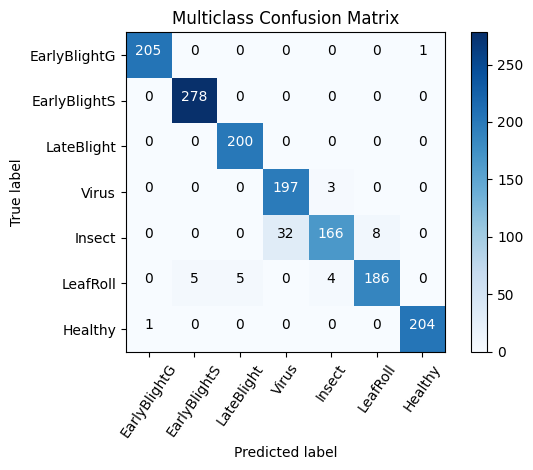

In [ ]:
Y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['EarlyBlightG','EarlyBlightS', 'LateBlight', 'Virus' , 'Insect','LeafRoll', 'Healthy']
plot_confusion_matrix(cm, cm_plot_label, title ='Multiclass Confusion Matrix')

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label = ['EarlyBlightG','EarlyBlightS', 'LateBlight', 'Virus' , 'Insect','LeafRoll', 'Healthy']
plot_confusion_matrix(cm, cm_plot_label, title='Multiclass Confusion Matrix')
plt.show()

47/47 [==============================] - 17s 354ms/step


AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('MultiNet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,6))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 6, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 6, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['EarlyBlight General','EarlyBlight Serious', 'LateBlight','Virus' , 'Insect','LeafRoll','Healthy' ]
print(classification_report(y_test, Y_pred, target_names=target_names))

47/47 [==============================] - 16s 353ms/step
Classification Report
                     precision    recall  f1-score   support

EarlyBlight General       1.00      1.00      1.00       206
EarlyBlight Serious       0.98      1.00      0.99       278
         LateBlight       0.98      1.00      0.99       200
              Virus       0.86      0.98      0.92       200
             Insect       0.96      0.81      0.88       206
           LeafRoll       0.96      0.93      0.94       200
            Healthy       1.00      1.00      1.00       205

           accuracy                           0.96      1495
          macro avg       0.96      0.96      0.96      1495
       weighted avg       0.96      0.96      0.96      1495



In [ ]:
pred=model.predict(X_test)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    precision_score,
    recall_score,
    mean_squared_error,
    mean_absolute_error
)

Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)

accuray = accuracy_score(Y_pred, y_test)
f1 = f1_score(Y_pred, y_test, average="weighted")
precision = precision_score(Y_pred, y_test, average='weighted')
recall = recall_score(Y_pred, y_test, average='weighted')
mse = mean_squared_error(Y_pred, y_test)
mae = mean_absolute_error(Y_pred, y_test)

print("MultiNet(ResNet50,DenseNet201,VGG16)")
print("Accuracy:", accuray)
print("F1 Score:", f1)
print("precision:", precision)
print("recall:", recall)
print("MSE:", mse)
print("MAE:", mae)

In [ ]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
Y_test=np.argmax(Y_test,1)

In [ ]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred, pos_label=6)
auc=metrics.auc(fpr, tpr)
auc

0.9951238419360937

In [ ]:
i = 0
prop_class = []
mis_class = []

for i in range(len(y_val)):
    if np.argmax(y_val[i]) == np.argmax(Y_pred[i]):
        prop_class.append(i)
    if len(prop_class) == 20:
        break

i = 0
for i in range(len(y_val)):
    if not np.argmax(y_val[i]) == np.argmax(Y_pred[i]):
        mis_class.append(i)
    if len(mis_class) == 20:
        break

# Display first 25 images
w = 60
h = 40
fig = plt.figure(figsize=(20, 20))
columns = 5
rows = 4

def transfer_name(name_code):
    if name_code == 0:
        return "Early Blight General"
    elif name_code == 1:
        return "Early Blight Serious"
    elif name_code == 2:
        return "Late Blight"
    elif name_code == 3:
        return "Virus"
    elif name_code == 4:
        return "Insect"
    elif name_code == 5:
        return "LeafRollVirus"
    else:
        return "Healthy"

for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.set_title("Predicted result: " + transfer_name(np.argmax(Y_pred[prop_class[i]]))
                 + "\n" + "Actual result: " + transfer_name(np.argmax(y_val[prop_class[i]])))
    plt.imshow(x_val[prop_class[i]], interpolation='nearest')

plt.show()


Output hidden; open in https://colab.research.google.com to view.